## 6 class AD PD model

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklvq import GMLVQ
from timeit import timeit
from sklearn.model_selection import KFold
from itertools import chain
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve,roc_auc_score,auc
import colorama
from colorama import Fore, Style
matplotlib.rc("xtick", labelsize="small")
matplotlib.rc("ytick", labelsize="small")

In [2]:
def getdata():
    data = pd.read_csv("feature_vectors.csv").to_numpy()
    labels = pd.read_csv("diagnosis_label.csv").to_numpy().squeeze()
    labelscenter = pd.read_csv("center_label.csv").to_numpy().squeeze()

    labelsfinal = labels + labelscenter
    
    # better way to perform this
    labelsdiseases1 = np.where(labelsfinal == 'HCUMCG') 
    centerlabels1 = labelsfinal[labelsdiseases1]
    labelsdiseases2 = np.where(labelsfinal == 'HCUGOSM') 
    #labelsdiseases = np.where(labels == 'HCCUN','1',centerlabels) 
    centerlabels2 = labelsfinal[labelsdiseases2]
    labelsdiseases3 = np.where(labelsfinal == 'HCCUN') 
    centerlabels3 = labelsfinal[labelsdiseases3]
    
    # better way to perform this
    centerlabels = np.concatenate((centerlabels1,centerlabels2,centerlabels3))
    centerdata = data[labelsdiseases1]
    centerdata = np.concatenate((centerdata,data[labelsdiseases2]))
    centerdata = np.concatenate((centerdata,data[labelsdiseases3]))
    
    scalar = StandardScaler()
    #data = ztransform(data,scaler)
    #centerdata= ztransform(centerdata,scaler)
    return data,labels,centerdata,centerlabels,labelscenter,scalar

In [3]:
def ztransform(data_ztransform,scalarz):
    # Sklearn's standardscaler to perform z-transform

    # Compute (fit) and apply (transform) z-transform
    # why do we do an inverse z transform
    #scalar = scalar
    data_ztransform = scalarz.fit_transform(data_ztransform)
    return data_ztransform,scalarz

In [4]:
class ProcessLogger:
    def __init__(self):
        self.states = np.array([])

    # A callback function has to accept two arguments, i.e., model and state, where model is the
    # current model, and state contains a number of the optimizers variables.
    def __call__(self, state):
        self.states = np.append(self.states, state)
        return False  # The callback function can also be used to stop training early,
        # if some condition is met by returning True.

        
        
logger = ProcessLogger()



In [5]:
def model_definition_center():
    
    model = GMLVQ(
    distance_type="adaptive-squared-euclidean",
    activation_type="sigmoid",
    activation_params={"beta": 2},
        #wgd
    solver_type="wgd",
    solver_params={"max_runs": 50,"step_size": np.array([0.1, 0.05]),"callback": logger},
    #solver_params={"max_runs": 10,"batch_size":1,"step_size": np.array([0.1, 0.05])},
    random_state=1428,)
    
    return model

In [6]:
def model_definition_disease(correctionmatrix):
    model1 = GMLVQ(
        distance_type="adaptive-squared-euclidean",
        activation_type="sigmoid",
        activation_params={"beta": 2},
        solver_type="wgd",
        solver_params={"max_runs": 50,"step_size": np.array([0.1, 0.05]),"callback": logger},
        #solver_params={"max_runs": 10,"batch_size":1,"step_size": np.array([0.1, 0.05])},
        random_state=1428,
        relevance_correction=correctionmatrix
    )
    return model1

In [7]:
def train_modelkfold(data, label,disease,correctionmatrix1,repeated,scalar,folds=5):
    modelmatrix = np.zeros((repeated,folds),dtype=object) 
    scalars = np.zeros((repeated,folds),dtype=object)
    datamatrix =  np.zeros((repeated,folds),dtype=object) 
    labelmatrix = np.zeros((repeated,folds),dtype=object)
    accuracies = np.zeros((repeated,folds),dtype=float) 
    # each entry will store the test labels and the predicted labels
    testlabels = np.zeros((repeated,folds),dtype=object) 
    predicted = np.zeros((repeated,folds),dtype=object) 
    probablities = np.zeros((repeated,folds),dtype=object) 
    laeblscore = np.zeros((repeated,folds),dtype=object) 
    testing_indicesM = np.zeros((repeated,folds),dtype=object) 
    traning_indicesM = np.zeros((repeated,folds),dtype=object) 
    
    if disease==False:
        print('Repeated K fold for center data')
    else:
        print('Repeated K fold for disease data')
    for repeated in range(repeated):
        
        print("========Repeated fold number",str(repeated),"========")
        kfold = KFold(folds, shuffle=True)
        
        for k, (training_indices, testing_indices) in enumerate(kfold.split(data)):
            if disease==False:
                model = model_definition_center()
                #print('in this')
                #print(type(model))
            else:
                #model = model_definition_center()
                model = model_definition_disease(correctionmatrix1)
            accuracy = 0
            correct = 0
            trainX, trainY, testX, testY = data[training_indices], label[training_indices], data[testing_indices], label[testing_indices]
            #applying z transform on training data only
            trainX,scalar1 = ztransform(trainX,scalar)
            model.fit(trainX,trainY)
            
            # model is fitted, can also do = model
            modelmatrix[repeated,k] = model
            datamatrix[repeated,k] = trainX
            
            
            labelmatrix[repeated,k] = trainY

            testX = scalar1.transform(testX)
            predictedlabels = model.predict(testX)
            #print(confusion_matrix(testX, predictedlabels))
            for i in range(len(predictedlabels)):
                if(predictedlabels[i]==testY[i]):
                    correct = correct+1
                    
            scalars[repeated,k] = scalar1
            
            probabilties = model.predict_proba(testX)
            
            laeblscore[repeated,k] = model.decision_function(testX)
            
            probablities[repeated,k] = probabilties
            
            testlabels[repeated,k] = testY
            
            predicted[repeated,k] = predictedlabels
            
            
            testing_indicesM[repeated,k] = testing_indices
            traning_indicesM[repeated,k] = training_indices
            # accuracy and error rate for the validation set(test set in kfold)
            accuracy = correct/len(testY)
            print('%.3f accuracy' % (correct/len(testY)))
            
            # could also plot same for the training set in the kfold
    return modelmatrix,datamatrix,labelmatrix,scalars,testlabels,predicted,probablities,laeblscore,testing_indicesM,traning_indicesM

In [8]:
def calculate_lambda(modelmatrix,repeated):
    #average_lambda = np.mean(sum(model.lambda_ for model in modellist),axis=0)
    #check the shape of total_lambda
    
    total_lambda = np.zeros((36,36),dtype = 'float')
    print(repeated)
    for index in range(repeated):
        print(index)
        lambdaperfold = np.zeros((36,36),dtype='float')        
        
        for modelin in modelmatrix[index,:]:
            lambdaperfold = lambdaperfold + modelin.lambda_

        lambdaperfold = lambdaperfold/np.shape(modelmatrix)[1]
        
        total_lambda = total_lambda + lambdaperfold
        
    total_lambda = total_lambda/repeated

    return total_lambda

In [9]:
def eigendecomposition(average_lambda):
    eigenvalues, eigenvectors = np.linalg.eigh(average_lambda)
    # eigen vectors returned in columns
    # Flip (reverse the order to descending) before assigning.
    eigenvalues = np.flip(eigenvalues)

    # eigenvectors are column matrix in ascending order. Flip the columns and transpose the matrix
    # to get the descending ordered row matrix.
    
    # eigenvectors are row matrices
    #eigenvectors = eigenvectors.T
    #eigenvectors = np.flip(eigenvectors,axis=0)
    eigenvectors = np.flip(eigenvectors, axis=1).T
    
    return eigenvalues,eigenvectors

In [10]:
feature_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','ab','ac','ad','ae','af','ag','ah','ai','aj','ak']


In [11]:

def correction_matrix(eigvectorscenter):
    N=36
    K=1
    I = np.identity(N)
    outerproduct = np.zeros((N,N))   
    for i in range(K):
        # check this
        outerproduct +=  np.outer(eigvectorscenter.T[:,i],eigvectorscenter[i,:])
        outerproduct1 =  np.outer(eigvectorscenter.T[:,0],eigvectorscenter[0,:])
        outerproduct2 =  np.outer(eigvectorscenter.T[:,1],eigvectorscenter[1,:])        
    correctionmatrix = I-outerproduct
    return correctionmatrix

In [12]:
def calculate_prototype(modelmatrix,repeated,dimension):
    #prototypeaverage = np.zeros((prototype,dimensions),dtype='float')    
    numberofprototypes = len(modelmatrix[0][0].prototypes_)
    prototypeaverage = np.zeros((numberofprototypes,dimension),dtype='float')    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    for modelin in range(len(modellist)):
        for i in range(numberofprototypes):
            prototypeaverage[i] = np.add(prototypeaverage[i],modellist[modelin].prototypes_[i])
    return prototypeaverage/len(modellist)

In [13]:
def calculate_eigenvaluesc(modelmatrix,repeated,dimension):
    #prototypeaverage = np.zeros((prototype,dimensions),dtype='float')    
    numberofprototypes = len(modelmatrix[0][0].prototypes_)
    prototypeaverage = np.zeros(dimension,dtype='float')    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    for modelin in range(len(modellist)):
        prototypeaverage = np.add(prototypeaverage,modellist[modelin].eigenvalues_)
    return prototypeaverage/len(modellist)

In [14]:
def calculate_eigenvaluesd(modelmatrix,repeated,dimension):
    #prototypeaverage = np.zeros((prototype,dimensions),dtype='float')    
    numberofprototypes = len(modelmatrix[0][0].prototypes_)
    prototypeaverage = np.zeros(dimension,dtype='float')    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    for modelin in range(len(modellist)):
        prototypeaverage = np.add(prototypeaverage,modellist[modelin].eigenvalues_)
    return prototypeaverage/len(modellist)

In [15]:
def calculate_eigenvectorsc(modelmatrix,repeated,dimension):
    #prototypeaverage = np.zeros((prototype,dimensions),dtype='float')    
    numberofprototypes = len(modelmatrix[0][0].eigenvectors_)
    prototypeaverage = np.zeros((numberofprototypes,dimension),dtype='float')    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    for modelin in range(len(modellist)):
        for i in range(numberofprototypes):
            prototypeaverage[i] = np.add(prototypeaverage[i],modellist[modelin].eigenvectors_[i])
    return prototypeaverage/len(modellist)

In [16]:
def calculate_eigenvectorsd(modelmatrix,repeated,dimension):
    #prototypeaverage = np.zeros((prototype,dimensions),dtype='float')    
    numberofprototypes = len(modelmatrix[0][0].eigenvectors_)
    prototypeaverage = np.zeros((numberofprototypes,dimension),dtype='float')    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    for modelin in range(len(modellist)):
        for i in range(numberofprototypes):
            prototypeaverage[i] = np.add(prototypeaverage[i],modellist[modelin].eigenvectors_[i])
    return prototypeaverage/len(modellist)

In [17]:
def calculate_prototype1(modelmatrix,repeated,dimension):
    #prototypeaverage = np.zeros((prototype,dimensions),dtype='float')    
    numberofprototypes = len(modelmatrix[0][0].prototypes_)
    prototypeaverage = np.zeros((numberofprototypes,dimension),dtype='float')    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    for modelin in range(len(modellist)):
        for i in range(numberofprototypes):
            prototypeaverage[i] = np.add(prototypeaverage[i],modellist[modelin].prototypes_[i])
    return prototypeaverage/len(modellist)

In [18]:
data,labels,centerdata1,centerlabels1,labelscenter,scalar = getdata()



######UMCG indices##########

#ADindices = np.where(labels=='AD')

UMCGindices = np.where(labelscenter=='UMCG')

# Remove UMCH 1st from data, centerlabels and diseaselabels


datanoUMCG = np.delete(data,UMCGindices,axis=0)

labelsnoUMCG = np.delete(labels,UMCGindices,axis=0)

labelscenternoUMCG = np.delete(labelscenter,UMCGindices,axis=0)



In [19]:
### get AD indices

ADindices = np.where(labelsnoUMCG=='AD')

# datacenter is the data with no umcg and AD incides

finaldatacenter = np.delete(datanoUMCG,ADindices,axis=0)

#Final center labels with no AD and UMCG
finalcenterlabels = np.delete(labelscenternoUMCG,ADindices,axis=0)


# labelsnoAD for disease data
labelsnoAD = np.delete(labelsnoUMCG,ADindices,axis=0)


In [20]:
### get HC indices and remove them for the disease data and labels
# fetching HC indices

healthycontrolindices = np.where(labelsnoAD=='HC')

finaldatadisease = np.delete(finaldatacenter,healthycontrolindices,axis=0)

labelsnoDHC = np.delete(labelsnoAD,healthycontrolindices,axis=0)

centernoHC = np.delete(finalcenterlabels,healthycontrolindices,axis=0)

##############

Finallabelsdisease = labelsnoDHC+centernoHC

## get data

In [21]:

centermodel,datamatrix,labelmatrix,scalars1,testlabelsc,predictedc,probabiltiesc,laeblscorec,testing_indicesC,training_indicesC = train_modelkfold(finaldatacenter,finalcenterlabels,False,None,10,scalar)

average_lambda_center = calculate_lambda(centermodel,10)

average_prototype_center = calculate_prototype(centermodel,10,36)


eigenvectorc =calculate_eigenvectorsc(centermodel,10,36)


eigenvaluec = calculate_eigenvaluesc(centermodel,10,36)

print('                                                     ')


print('The sum of the digonal of the center relevance matrix')

print(np.sum(np.diagonal(average_lambda_center)))

print('                                                     ')


eigenvaluescenter,eigenvectorscenter= eigendecomposition(average_lambda_center)


correctionmatrix1 = correction_matrix(eigenvectorscenter)

#correctionmatrix = correction_matrix()


Repeated K fold for center data
========Repeated fold number 0 ========
1.000 accuracy
0.941 accuracy
1.000 accuracy
1.000 accuracy
0.970 accuracy
========Repeated fold number 1 ========
1.000 accuracy
0.971 accuracy
0.971 accuracy
1.000 accuracy
0.970 accuracy
========Repeated fold number 2 ========
0.971 accuracy
1.000 accuracy
1.000 accuracy
0.970 accuracy
1.000 accuracy
========Repeated fold number 3 ========
0.941 accuracy
1.000 accuracy
0.971 accuracy
1.000 accuracy
1.000 accuracy
========Repeated fold number 4 ========
0.971 accuracy
1.000 accuracy
0.971 accuracy
1.000 accuracy
1.000 accuracy
========Repeated fold number 5 ========
0.971 accuracy
1.000 accuracy
0.971 accuracy
0.970 accuracy
0.970 accuracy
========Repeated fold number 6 ========
0.941 accuracy
0.971 accuracy
0.971 accuracy
1.000 accuracy
0.970 accuracy
========Repeated fold number 7 ========
0.941 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
========Repeated fold number 8 ========
1.000 ac

## center data fitting (3 class)

In [22]:

diseasemodel,datamatrix1,labelmatrix1,scalars2,testlabelsd,predictedd,probabiltiesd,laeblscored,testing_indicesD,training_indicesD  = train_modelkfold(finaldatadisease,Finallabelsdisease,True,correctionmatrix1,10,scalar)

average_lambda_disease = calculate_lambda(diseasemodel,10)

eigenvaluesdisease,eigenvectorsdisease = eigendecomposition(average_lambda_disease)

average_prototype_disease = calculate_prototype1(diseasemodel,10,36)

eigenvectord=calculate_eigenvectorsd(diseasemodel,10,36)

eigenvalued = calculate_eigenvaluesd(centermodel,10,36)



print('The sum of the digonal of the disease relevance matrix')

print(np.sum(np.diagonal(average_lambda_disease)))


Repeated K fold for disease data
========Repeated fold number 0 ========
0.905 accuracy
0.952 accuracy
0.762 accuracy
0.762 accuracy
0.762 accuracy
========Repeated fold number 1 ========
0.762 accuracy
0.905 accuracy
0.714 accuracy
0.714 accuracy
1.000 accuracy
========Repeated fold number 2 ========
0.857 accuracy
0.762 accuracy
0.857 accuracy
0.857 accuracy
0.714 accuracy
========Repeated fold number 3 ========
0.762 accuracy
0.857 accuracy
0.952 accuracy
0.857 accuracy
0.952 accuracy
========Repeated fold number 4 ========
0.857 accuracy
0.762 accuracy
0.762 accuracy
0.952 accuracy
0.857 accuracy
========Repeated fold number 5 ========
0.905 accuracy
0.810 accuracy
0.857 accuracy
0.905 accuracy
0.810 accuracy
========Repeated fold number 6 ========
0.857 accuracy
0.857 accuracy
0.810 accuracy
0.810 accuracy
0.857 accuracy
========Repeated fold number 7 ========
0.810 accuracy
0.952 accuracy
0.857 accuracy
0.857 accuracy
0.762 accuracy
========Repeated fold number 8 ========
0.905 a

## single model trained on 4 class disease and 3 class center data

In [23]:
# training an individual model
modelc = model_definition_center()
centerdata1,scalarIc = ztransform(finaldatacenter,scalar)

modelc.fit(finaldatacenter,finalcenterlabels)

correctionmatrix12 = correction_matrix(modelc.eigenvectors_)
datanoHC,scalarId = ztransform(finaldatadisease,scalar)

modeld = model_definition_disease(correctionmatrix12)

modeld.fit(finaldatadisease,Finallabelsdisease)
predictedlabels = modeld.predict(finaldatadisease)

## Zero dot product

In [24]:
# removed the influence of the leading eigen vector from each 
first_eigen_vector = np.dot(diseasemodel[0][3].eigenvectors_[0,:],eigenvectorscenter[0,:])
print(first_eigen_vector)

5.551115123125783e-17


In [25]:
def check_orthogonality(centermodel,diseasemodel,dimensions,repeated,folds,eigenvectorscenter):
    centerlist = list(chain.from_iterable(zip(*centermodel)))
    disease_center = list()
    disease_averagecenter= list()
    for j in range(2):
        for array,modeld in enumerate(diseasemodel[j]):
            disease_averagecenter.append(np.dot(modeld.eigenvectors_[:2,:],eigenvectorscenter[:2,:].T))
            for modelc in centerlist:
                # eigenvectors are row vectors
                disease_center.append((np.dot(modeld.eigenvectors_[:2,:],modelc.eigenvectors_[:2,:].T)))
    return disease_averagecenter,disease_center

In [26]:
from sklearn.utils.validation import check_is_fitted, check_array
def transform1(X,eigenvaluesaverage,eigenvectoraverage,scale):
    X = check_array(X)
    eigenvaluesaverage[eigenvaluesaverage < 0] = 0
    eigenvectoraverage = np.sqrt(eigenvaluesaverage[:, None]) * eigenvectoraverage
    if scale:
        return np.matmul(X, eigenvectoraverage.T)
    return np.matmul(X, eigenvectoraverage.T)

In [27]:
modeld.classes_

array(['PDCUN', 'PDUGOSM'], dtype=object)

In [28]:
confusion_matrix(testlabelsd[0][0],predictedd[0][1], labels=['PDCUN', 'PDUGOSM']).ravel()

array([14,  2,  1,  4])

In [29]:
def confusionmatrix(test,predicted):
    PDCUNPDCUN=PDCUNPDUGOSM=PDUGOSMPDCUN=PDUGOSMPDUGOSM=0
    PDCUNPDCUN,PDCUNPDUGOSM,PDUGOSMPDCUN,PDUGOSMPDUGOSM = confusion_matrix(test, predicted, labels=['PDCUN', 'PDUGOSM']).ravel()
            
    return PDCUNPDCUN,PDCUNPDUGOSM,PDUGOSMPDCUN,PDUGOSMPDUGOSM
            

In [30]:
def confusionmatrix_61class(modelmatrix,testlabelmatrix,predictedlabelmatrix):
    #testlist = list(chain.from_iterable(zip(*testlabelmatrix)))
    #predictedlist = list(chain.from_iterable(zip(*predictedlabelmatrix)))
    #1class only passing one set of test and predicted labels
    testlist = testlabelmatrix
    predictedlist = predictedlabelmatrix


    #testlist= testlist.astype(int)
    #predictedlist = predictlist.astype(int)
    PDCUN_tpr = dict()
    PDCUN_fpr = dict()
    
    
    PDUGOSM_tpr = dict()
    PDUGOSM_fpr = dict()
    
    nPDCUN_fpr=nPDCUN_tpr= nPDUGOSM_fpr= nPDUGOSM_tpr=0
    
    
    PDCUNPDCUN,PDCUNPDUGOSM,PDUGOSMPDCUN,PDUGOSMPDUGOSM  = confusionmatrix(testlabelmatrix,predictedlabelmatrix)
        
    nPDCUN_fpr = (PDUGOSMPDCUN)/(PDUGOSMPDCUN+PDUGOSMPDUGOSM)
    nPDCUN_tpr = (PDCUNPDCUN)/(PDCUNPDCUN+PDCUNPDUGOSM)


    nPDUGOSM_fpr = (PDCUNPDUGOSM)/(PDCUNPDUGOSM+PDCUNPDCUN)
    nPDUGOSM_tpr = (PDUGOSMPDUGOSM)/(PDUGOSMPDUGOSM+PDUGOSMPDCUN)

    #############################
    PDCUN_fpr = nPDCUN_fpr
    PDCUN_tpr = nPDCUN_tpr
    
    
    PDUGOSM_fpr = nPDUGOSM_fpr
    PDUGOSM_tpr = nPDUGOSM_tpr
    # add to the dictionary
    #pd_fpr[i].append(npd_fpr)
    #pd_tpr[i].append(npd_tpr)
    #ad_fpr[i].append(nad_fpr)
    #ad_tpr[i].append(nad_tpr)

#return PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,ADUGOSM_PDCUN ,ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG
    return PDCUN_fpr,PDCUN_tpr,PDUGOSM_fpr,PDUGOSM_tpr

In [31]:
def confusionmatrix_6class(modelmatrix,testlabelmatrix,predictedlabelmatrix):
    testlist = list(chain.from_iterable(zip(*testlabelmatrix)))
    predictedlist = list(chain.from_iterable(zip(*predictedlabelmatrix)))
    # storing the values 


    #testlist= testlist.astype(int)
    #predictedlist = predictlist.astype(int)
    PDCUN_tpr = dict()
    PDCUN_fpr = dict()
    
    
    PDUGOSM_tpr = dict()
    PDUGOSM_fpr = dict()
    
    
    for i in range(len(testlist)):
        nPDCUN_fpr=nPDCUN_tpr= nPDUGOSM_fpr= nPDUGOSM_tpr=0
        PDCUNPDCUN,PDCUNPDUGOSM,PDUGOSMPDCUN,PDUGOSMPDUGOSM  = confusionmatrix(testlist[i],predictedlist[i])

        nPDCUN_fpr = (PDUGOSMPDCUN)/(PDUGOSMPDCUN+PDUGOSMPDUGOSM)
        nPDCUN_tpr = (PDCUNPDCUN)/(PDCUNPDCUN+PDCUNPDUGOSM)


        nPDUGOSM_fpr = (PDCUNPDUGOSM)/(PDCUNPDUGOSM+PDCUNPDCUN)
        nPDUGOSM_tpr = (PDUGOSMPDUGOSM)/(PDUGOSMPDUGOSM+PDUGOSMPDCUN)

        #############################
        PDCUN_fpr[i] = nPDCUN_fpr
        PDCUN_tpr[i] = nPDCUN_tpr


        PDUGOSM_fpr[i] = nPDUGOSM_fpr
        PDUGOSM_tpr[i] = nPDUGOSM_tpr

#return PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,ADUGOSM_PDCUN ,ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG
    return PDCUN_fpr,PDCUN_tpr,PDUGOSM_fpr,PDUGOSM_tpr

## confusion matrix 

In [32]:
testlabelsdsingle = np.concatenate(list(chain.from_iterable(zip(*testlabelsd))), axis=0 )
predicteddsingle = np.concatenate( list(chain.from_iterable(zip(*predictedd))), axis=0 )
probabiltysingle = np.concatenate( list(chain.from_iterable(zip(*probabiltiesd))), axis=0 )

## confusion matrix for kfold models

In [33]:
PDCUN_fpr,PDCUN_tpr,PDUGOSM_fpr,PDUGOSM_tpr = confusionmatrix_6class(diseasemodel,testlabelsd,predictedd)

PDCUN_fpr1,PDCUN_tpr1,PDUGOSM_fpr1,PDUGOSM_tpr1 = confusionmatrix_61class(diseasemodel,testlabelsdsingle,predicteddsingle)

## create dictionary for models and an averaged model

In [34]:
n_classes=['PDCUN', 'PDUGOSM']
plotdict_tpr1 = dict()
plotdict_fpr1 = dict()

plotdict_tpr1 = PDCUN_tpr1,PDUGOSM_tpr1
plotdict_fpr1 = PDCUN_fpr1,PDUGOSM_fpr1

In [35]:
n_classes=['PDCUN', 'PDUGOSM']
plotdict_tpr = dict()
plotdict_fpr = dict()

#for j in range(len(repeated)*folds):
for j in range(10*5):

    
    plotdict_tpr[j] = PDCUN_tpr[j],PDUGOSM_tpr[j]
    plotdict_fpr[j]= PDCUN_fpr[j],PDUGOSM_fpr[j]

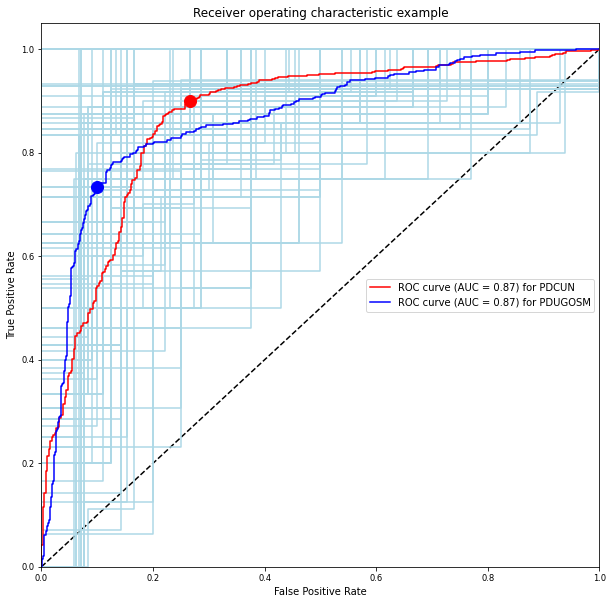

In [36]:
testlist = list(chain.from_iterable(zip(*testlabelsd)))
probabiltylist = list(chain.from_iterable(zip(*probabiltiesd)))
fpru = dict()
tpru = dict()
roc_aucu = dict()
for k in range(len(testlist)):

    n_classes=['PDCUN', 'PDUGOSM']
    # structures
    fpr = dict()

    tpr = dict()

    roc_auc = dict()
    
    
    
    fpr1 = dict()

    tpr1 = dict()

    roc_auc1 = dict()
    

    colorrange = ['lightblue','lightblue','lightblue']
    colorrange2 = ['red','blue','green']
    for i in range(len(n_classes)):
        fpr[i], tpr[i], _ = roc_curve(testlist[k],probabiltylist[k][:,i],pos_label=n_classes[i], drop_intermediate=True)
        roc_auc[i] = auc(fpr[i], tpr[i])
        fpru[k] = fpr
        tpru[k] = tpr
        roc_aucu[k] = roc_auc
        
    for j in range(len(n_classes)):
        fpr1[j], tpr1[j], _ = roc_curve(testlabelsdsingle,probabiltysingle[:,j],pos_label=n_classes[j], drop_intermediate=True)
        roc_auc1[j] = auc(fpr1[j], tpr1[j])

    
    
    
figsize=(10, 10)
# roc for each class
fig, ax = plt.subplots(figsize=figsize)



ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example') 


for k1 in range(len(testlist)):
    for i1 in range(len(n_classes)):  
        ax.plot(fpru[k1][i1], tpru[k1][i1], label='_nolegend_',color=colorrange[i1])

        #ax.plot(PDCUN_fpr[i], PDCUN_fpr[i],  marker="o", markersize="12")
        ax.plot(plotdict_fpr[k1][i1], plotdict_tpr[k][i1],  color=colorrange[i])#,marker="o", markersize="12")
        
        
#plotdict_tpr1 = ADUGOSM_tpr1,ADUMCG_tpr1,PDCUN_tpr1,PDUGOSM_tpr1,PDUMCG_tpr1
#plotdict_fpr1 = ADUGOSM_fpr1,ADUMCG_fpr1,PDCUN_tpr1,PDUGOSM_fpr1,PDUMCG_fpr1

for i2 in range(len(n_classes)):
    ax.plot(fpr1[i2], tpr1[i2], label='ROC curve (AUC = %0.2f) for %s' % (roc_auc1[i2], n_classes[i2]),color=colorrange2[i2])
    ax.plot(plotdict_fpr1[i2], plotdict_tpr1[i2], color=colorrange2[i2],marker="o", markersize="12")

ax.legend(loc="right")   
ax.grid(False)
fig.savefig('roc6class.png')
#ax.grid(alpha=.4)
plt.show()

In [37]:
roc_auc1

{0: 0.866555380989788, 1: 0.8665553809897879}

In [38]:
ax.plot(fpru[k][i], tpru[k][i], label='ROC curve (AUC = %0.2f) for %s' % (roc_aucu[k][i], n_classes[i]),color=colorrange[i])

## The area under the curve is used for binary classification. Therefore for each disease every other 4 sets of diseases are a negavive(not being sick). 
##For example:
##    ADUGOSM ---> positive
##    ADUMCG, PDCUN, PDUGOSM, PDUMCG ---> negative
##    For each such set tpr and fpr is calcualated which is different. Therefore there are different Area under the curves values. 
## either that or if required AUC per disease per center can be plotted in a different plot
## averegae AUC cuve:- explain logic from bookmarks



# makes sense because correction applied to the average disease lambda, while below refers to individual model


## ROC curve for one trained model for 6 class classification

## visualize models 6 class

In [39]:
# removing the z transform
def visualizeSinglemodeld(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,prototypes1):
    data = scalarI.inverse_transform(data)    
    transformed_data = model.transform(data,True)
    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]

    # Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
    # prototype inverser transform
    prototypes = scalarI.inverse_transform(prototypes1)

    transformed_model = model.transform(prototypes, scale=True)

    #transformed_model = transform1(prototypes,eigenvaluesaverage,eigenvectoraverage,scale=True)

    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]

    fig, ax = plt.subplots()
    fig.suptitle("Maindataset disease data with corresponding prototypes")
    colors = ['pink','magenta']#,'red','lightgreen']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('disease_correction_singelmodel.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

In [47]:
# removing the z transform
def averageprototype(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,average_prototype):
    data = scalarI.inverse_transform(data)
    transformed_data = transform1(data,eigenvaluesdisease,eigenvectoraverage,True)

    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]


    #transformed_model = model.transform(prototypes, scale=True)
    prototypes = scalarI.inverse_transform(average_prototype)
    transformed_model = transform1(prototypes,eigenvaluesaverage,eigenvectoraverage,scale=True)
    #transformed_model = model.transform(prototypes, scale=True)
    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]
    fig, ax = plt.subplots()
    fig.suptitle("Maindataset disease data with corresponding prototypes")
    colors = ['pink','magenta']#,'red','lightgreen']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('disease_correction_singelmodel_kfold.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

returning if
returning if
['PDCUN' 'PDUGOSM']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 
returning if
returning if
['CUN' 'UGOSM']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 
['PDCUN' 'PDUGOSM']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 
['CUN' 'UGOSM']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 


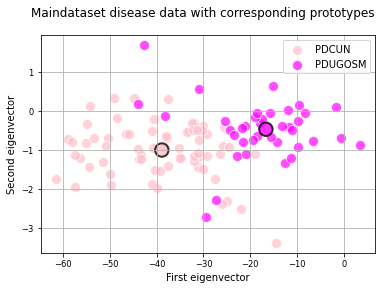

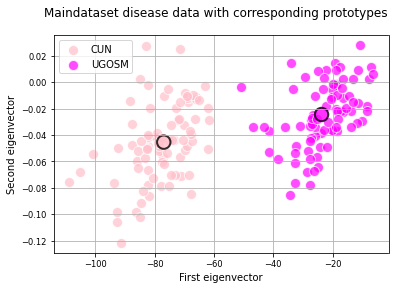

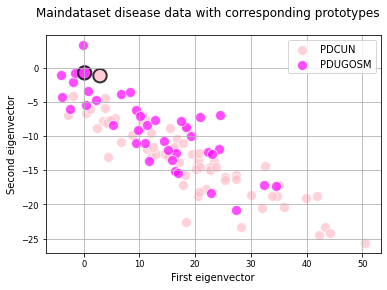

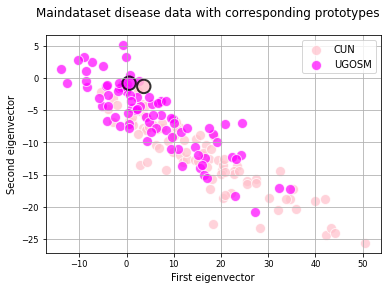

In [54]:
visualizeSinglemodeld(modeld,scalarId,finaldatadisease,Finallabelsdisease,modeld.eigenvalues_,modeld.eigenvectors_,modeld.prototypes_)

visualizeSinglemodeld(modelc,scalarIc,finaldatacenter,finalcenterlabels,modelc.eigenvalues_,modelc.eigenvectors_,modelc.prototypes_)

averageprototype(modeld,scalar,finaldatadisease,Finallabelsdisease,eigenvaluesdisease,eigenvectorsdisease,average_prototype_disease)

averageprototype(modelc,scalarIc,finaldatacenter,finalcenterlabels,eigenvaluesdisease,eigenvectorsdisease,average_prototype_center)

# visualize_diseaseaverage(diseasemodel[0][2],scalars2[0][2],datamatrix1[0][2],labelmatrix1[0][2],eigenvaluesdisease,eigenvectorsdisease)
#eigenvectorc  eigenvaluec eigenvectord eigenvalued

#visualizeSinglemodeld(diseasemodel[0][3],scalars2[0][3],datamatrix1[0][3],labelmatrix1[0][3],diseasemodel[0][3].eigenvalues_,diseasemodel[0][3].eigenvectors_,diseasemodel[0][3].prototypes_)
#averageprototype(centermodel[0][2],scalars1[0][2],finaldatacenter,finalcenterlabels,eigenvaluesdisease,eigenvectorsdisease,average_prototype_center)

# Trained on 2 class but visualised with 6 class, below list
#visualize_diseaseaverage(diseasemodel[0][2],scalars2[0][2],datamatrix1[0][2],labelmatrix1[0][2],eigenvaluesdisease,eigenvectorsdisease)
#visualize_disease(diseasemodel[0][2],scalars2[0][2],datamatrix1[0][2],labelmatrix1[0][2])

In [51]:
(average_prototype_disease)

array([[ 0.24365044,  0.14659085, -0.03953944, -0.2351036 , -0.34929399,
        -0.18858381,  0.23274718, -0.21526606, -0.20433439,  0.44027586,
        -0.10425857, -0.08259817, -0.28926443, -0.25923016, -0.21531644,
        -0.1048679 , -0.06138523, -0.0656376 ,  0.25371131,  0.03454727,
        -0.01656982, -0.08185418, -0.03473836, -0.21669664, -0.16192321,
        -0.14061329,  0.27349153,  0.05009512,  0.28798509,  0.08304489,
         0.04294857, -0.02842941, -0.10037403, -0.13010784,  0.69452415,
        -0.0355742 ],
       [-0.53060736, -0.36778222, -0.17332307,  0.22567469,  0.64184018,
         0.40281984, -0.3732316 ,  0.53661568,  0.63122002, -0.84879297,
         0.39758642,  0.27795775,  0.76871196,  0.59706645,  0.52716433,
         0.12948331,  0.09544434,  0.12384604, -0.74259251, -0.24875346,
        -0.00802014,  0.13558985,  0.2257437 ,  0.47528927,  0.28389916,
         0.23581873, -0.5788655 , -0.12536917, -0.60804531, -0.17525377,
        -0.23459538,  0.18696

In [49]:
diseasemodel[0][0].prototypes_[0] +  diseasemodel[0][1].prototypes_[0] + diseasemodel[0][2].prototypes_[0] + diseasemodel[0][3].prototypes_[0]+   diseasemodel[0][4].prototypes_[0] + diseasemodel[1][0].prototypes_[0] +  diseasemodel[1][1].prototypes_[0] + diseasemodel[1][2].prototypes_[0] + diseasemodel[1][3].prototypes_[0]+   diseasemodel[1][4].prototypes_[0]+diseasemodel[2][0].prototypes_[0] +  diseasemodel[2][1].prototypes_[0] + diseasemodel[2][2].prototypes_[0] + diseasemodel[2][3].prototypes_[0]+   diseasemodel[2][4].prototypes_[0]+diseasemodel[3][0].prototypes_[0] +  diseasemodel[3][1].prototypes_[0] + diseasemodel[3][2].prototypes_[0] + diseasemodel[3][3].prototypes_[0]+   diseasemodel[3][4].prototypes_[0]+diseasemodel[4][0].prototypes_[0] +  diseasemodel[4][1].prototypes_[0] + diseasemodel[4][2].prototypes_[0] + diseasemodel[4][3].prototypes_[0]+   diseasemodel[4][4].prototypes_[0]+diseasemodel[5][0].prototypes_[0] +  diseasemodel[5][1].prototypes_[0] + diseasemodel[5][2].prototypes_[0] + diseasemodel[5][3].prototypes_[0]+   diseasemodel[5][4].prototypes_[0]+diseasemodel[6][0].prototypes_[0] +  diseasemodel[6][1].prototypes_[0] + diseasemodel[6][2].prototypes_[0] + diseasemodel[6][3].prototypes_[0]+   diseasemodel[6][4].prototypes_[0]++diseasemodel[7][0].prototypes_[0] +  diseasemodel[7][1].prototypes_[0] + diseasemodel[7][2].prototypes_[0] + diseasemodel[7][3].prototypes_[0]+   diseasemodel[7][4].prototypes_[0]+diseasemodel[8][0].prototypes_[0] +  diseasemodel[8][1].prototypes_[0] + diseasemodel[8][2].prototypes_[0] + diseasemodel[8][3].prototypes_[0]+   diseasemodel[8][4].prototypes_[0]+diseasemodel[9][0].prototypes_[0] +  diseasemodel[9][1].prototypes_[0] + diseasemodel[9][2].prototypes_[0] + diseasemodel[9][3].prototypes_[0]+   diseasemodel[9][4].prototypes_[0]

array([ 12.27131584,   7.29409991,  -1.89555492, -11.74913929,
       -17.55256761,  -9.3119052 ,  11.49041538, -10.52717241,
       -10.30055702,  21.91734599,  -5.26300545,  -4.14289854,
       -14.51329309, -12.8343305 , -10.51591911,  -5.22373016,
        -3.18102354,  -3.34740875,  12.65342342,   1.68544033,
        -0.7374589 ,  -4.10419052,  -1.65465991, -10.88795889,
        -8.26646   ,  -7.21722912,  13.54858924,   2.46073962,
        14.4286145 ,   4.13928765,   1.95349776,  -1.39876807,
        -4.99377142,  -6.74067923,  34.73897059,  -2.01941289])

In [53]:
 -11.74913929/50

-0.2349827858

In [47]:
c/50

array([ 0.24365044,  0.14659085, -0.03953944, -0.2351036 , -0.34929399,
       -0.18858381,  0.23274718, -0.21526606, -0.20433439,  0.44027586,
       -0.10425857, -0.08259817, -0.28926443, -0.25923016, -0.21531644,
       -0.1048679 , -0.06138523, -0.0656376 ,  0.25371131,  0.03454727,
       -0.01656982, -0.08185418, -0.03473836, -0.21669664, -0.16192321,
       -0.14061329,  0.27349153,  0.05009512,  0.28798509,  0.08304489,
        0.04294857, -0.02842941, -0.10037403, -0.13010784,  0.69452415,
       -0.0355742 ])

In [48]:
a1 = diseasemodel[0][0].prototypes_[1] +  diseasemodel[0][1].prototypes_[1] + diseasemodel[0][2].prototypes_[1] + diseasemodel[0][3].prototypes_[1]+   diseasemodel[0][4].prototypes_[1] + diseasemodel[1][0].prototypes_[1] +  diseasemodel[1][1].prototypes_[1] + diseasemodel[1][2].prototypes_[1] + diseasemodel[1][3].prototypes_[1]+   diseasemodel[1][4].prototypes_[1]+diseasemodel[2][0].prototypes_[1] +  diseasemodel[2][1].prototypes_[1] + diseasemodel[2][2].prototypes_[1] + diseasemodel[2][3].prototypes_[1]+   diseasemodel[2][4].prototypes_[1]+diseasemodel[3][0].prototypes_[1] +  diseasemodel[3][1].prototypes_[1] + diseasemodel[3][2].prototypes_[1] + diseasemodel[3][3].prototypes_[1]+   diseasemodel[3][4].prototypes_[1]+diseasemodel[4][0].prototypes_[1] +  diseasemodel[4][1].prototypes_[1] + diseasemodel[4][2].prototypes_[1] + diseasemodel[4][3].prototypes_[1]+   diseasemodel[4][4].prototypes_[1]+diseasemodel[5][0].prototypes_[1] +  diseasemodel[5][1].prototypes_[1] + diseasemodel[5][2].prototypes_[1] + diseasemodel[5][3].prototypes_[1]+   diseasemodel[5][4].prototypes_[1]+diseasemodel[6][0].prototypes_[1] +  diseasemodel[6][1].prototypes_[1] + diseasemodel[6][2].prototypes_[1] + diseasemodel[6][3].prototypes_[1]+   diseasemodel[6][4].prototypes_[1]++diseasemodel[7][0].prototypes_[1] +  diseasemodel[7][1].prototypes_[1] + diseasemodel[7][2].prototypes_[1] + diseasemodel[7][3].prototypes_[1]+   diseasemodel[7][4].prototypes_[1]+diseasemodel[8][0].prototypes_[1] +  diseasemodel[8][1].prototypes_[1] + diseasemodel[8][2].prototypes_[1] + diseasemodel[8][3].prototypes_[1]+   diseasemodel[8][4].prototypes_[1]+diseasemodel[9][0].prototypes_[1] +  diseasemodel[9][1].prototypes_[1] + diseasemodel[9][2].prototypes_[1] + diseasemodel[9][3].prototypes_[1]+   diseasemodel[9][4].prototypes_[1]

In [49]:
a1/50

array([-0.53060736, -0.36778222, -0.17332307,  0.22567469,  0.64184018,
        0.40281984, -0.3732316 ,  0.53661568,  0.63122002, -0.84879297,
        0.39758642,  0.27795775,  0.76871196,  0.59706645,  0.52716433,
        0.12948331,  0.09544434,  0.12384604, -0.74259251, -0.24875346,
       -0.00802014,  0.13558985,  0.2257437 ,  0.47528927,  0.28389916,
        0.23581873, -0.5788655 , -0.12536917, -0.60804531, -0.17525377,
       -0.23459538,  0.18696321,  0.24680714,  0.13714572, -1.22022238,
       -0.23595839])

In [55]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
def ploteigenvalues(eigenvalues,eigenvectors,average_lambda,d):
    fig, ax = plt.subplots()
    fig.suptitle("Eigen values with correction "+d+ " main data")
    ax.bar(range(0, len(eigenvalues)), eigenvalues)
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('eigenvalues'+d+'.eps', format='eps')
    fig.savefig('eigenvalues'+d+'.png')
    #fig.savefig('eigenvalues+d+.svg", format ='svg', dpi=1200)


    # Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
    fig, ax = plt.subplots()
    fig.suptitle("First Eigenvector with correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[0, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Firsteigenvector'+d+'.eps', format='eps')
    fig.savefig('Firsteigenvector'+d+'.png')
    
    fig, ax = plt.subplots()
    fig.suptitle("Second Eigenvector with correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[1, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Secondeigenvector'+d+'.eps', format='eps')
    fig.savefig('Secondeigenvector'+d+'.png')
    fig, ax = plt.subplots()
    # The relevance matrix is available after fitting the model.
    relevance_matrix = average_lambda
    fig.suptitle("Relevance Matrix Diagonal with correction " +d+ " main data")
    ax.bar(feature_names, np.diagonal(relevance_matrix))
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('relevancematrix'+d+'.eps', format='eps')
    fig.savefig('relevancematrix'+d+'.png')

In [56]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
def ploteigenvalueswithout(eigenvalues,eigenvectors,average_lambda,d):
    fig, ax = plt.subplots()
    fig.suptitle("Eigen values without correction "+d+ " main data")
    ax.bar(range(0, len(eigenvalues)), eigenvalues)
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('eigenvalues'+d+'.eps', format='eps')
    fig.savefig('eigenvalues'+d+'.png')
    #fig.savefig('eigenvalues+d+.svg", format ='svg', dpi=1200)


    # Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
    fig, ax = plt.subplots()
    fig.suptitle("First Eigenvector without correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[0, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Firsteigenvector'+d+'.eps', format='eps')
    fig.savefig('Firsteigenvector'+d+'.png')
    
    fig, ax = plt.subplots()
    fig.suptitle("Second Eigenvector without correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[1, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Secondeigenvector'+d+'.eps', format='eps')
    fig.savefig('Secondeigenvector'+d+'.png')
    fig, ax = plt.subplots()
    # The relevance matrix is available after fitting the model.
    relevance_matrix = average_lambda
    fig.suptitle("Relevance Matrix Diagonal without correction " +d+ " main data")
    ax.bar(feature_names, np.diagonal(relevance_matrix))
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('relevancematrix'+d+'.eps', format='eps')
    fig.savefig('relevancematrix'+d+'.png')

In [57]:
## average 

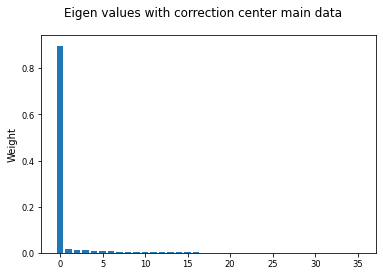

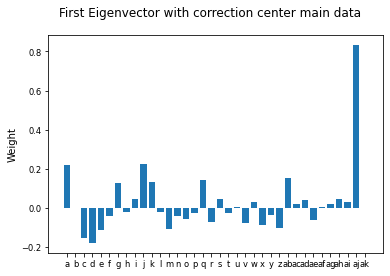

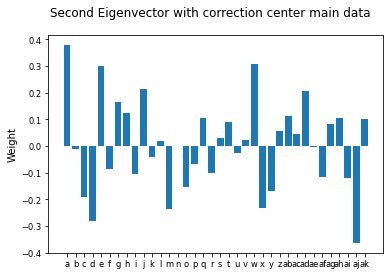

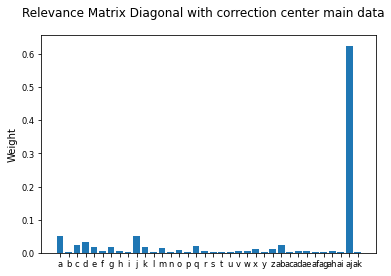

In [58]:
ploteigenvalues(eigenvaluescenter,eigenvectorscenter,average_lambda_center,'center')

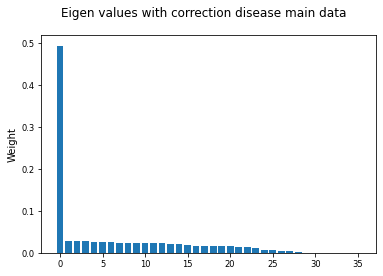

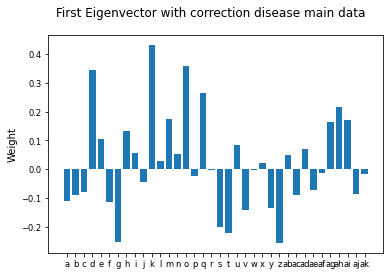

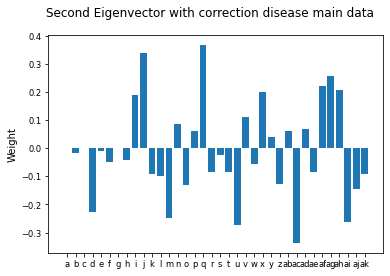

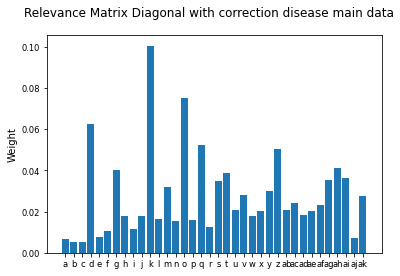

In [59]:
ploteigenvalues(modeld.eigenvalues_,modeld.eigenvectors_,modeld.lambda_,'disease')

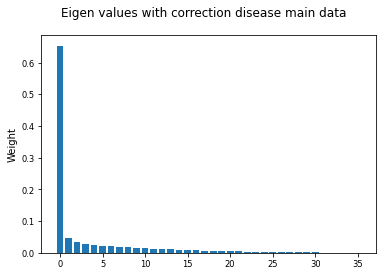

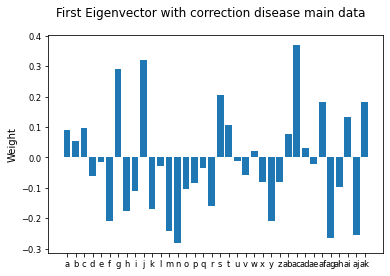

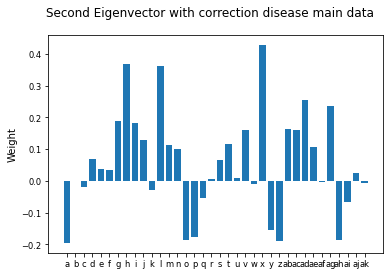

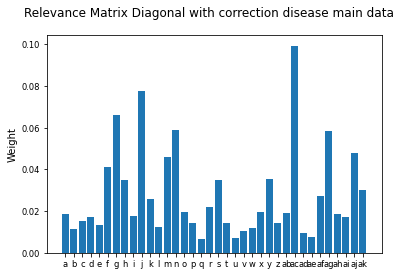

In [60]:
ploteigenvalues(eigenvaluesdisease,eigenvectorsdisease,average_lambda_disease,'disease')

In [ ]:
ploteigenvalues(modelc.eigenvalues_,modelc.eigenvectors_,modelc.lambda_,'disease')